# Process the CSV files from Prakash into MMC profiles

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd 
import numpy as np
import os

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def filtertime(tvec, t1, t2):
    mask = []
    for t in tvec:
        if (t1 <= np.datetime64(t)) and (np.datetime64(t) <= t2):
            mask.append(True)
        else:
            mask.append(False)
    return mask

def timedelta(tvec, tbase):
    tsecs = []
    for t in tvec:
        tsecs.append()

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx, a.flat[idx]

In [3]:
csvdir = '../../NOW23_analysis/plots/stable'
csvfile = '2020-02-04-8100.csv'
tstart = np.datetime64('2020-02-04T04:50')

In [4]:
df = pd.read_csv(csvdir+'/'+csvfile)

In [5]:
# Process the times
alltimes = df['time'].unique()
tstart   = np.datetime64(alltimes[0])

alltimessec = []
for t in alltimes:
    alltimessec.append((np.datetime64(t)-tstart)/np.timedelta64(1, 's'))

/tmp/ipykernel_189531/1604252347.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tstart   = np.datetime64(alltimes[0])
/tmp/ipykernel_189531/1604252347.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  alltimessec.append((np.datetime64(t)-tstart)/np.timedelta64(1, 's'))


In [6]:
# Set up the all profiles dictionary
allprofiles = {}
allvars = list(df.columns)

# Print available headers
print(allvars)

for col in allvars:
    allprofiles[col] = []

# Extract out the profiles
for t in alltimes:
    df_at_time = df.loc[df['time']==t]
    for col in allvars:
        allprofiles[col].append(df_at_time[col].values)

for col in allvars:
    allprofiles[col] = np.array(allprofiles[col])

['time', 'height', 'wind_speed', 'wind_direction', 'temperature', 'virtual_temperature', 'tke', 'sst', 'surface_heat_flux', 'invMOL', 'ustar', 'time.1', 'height.1', 'u', 'v', 'is_stable', 'stable_duration']


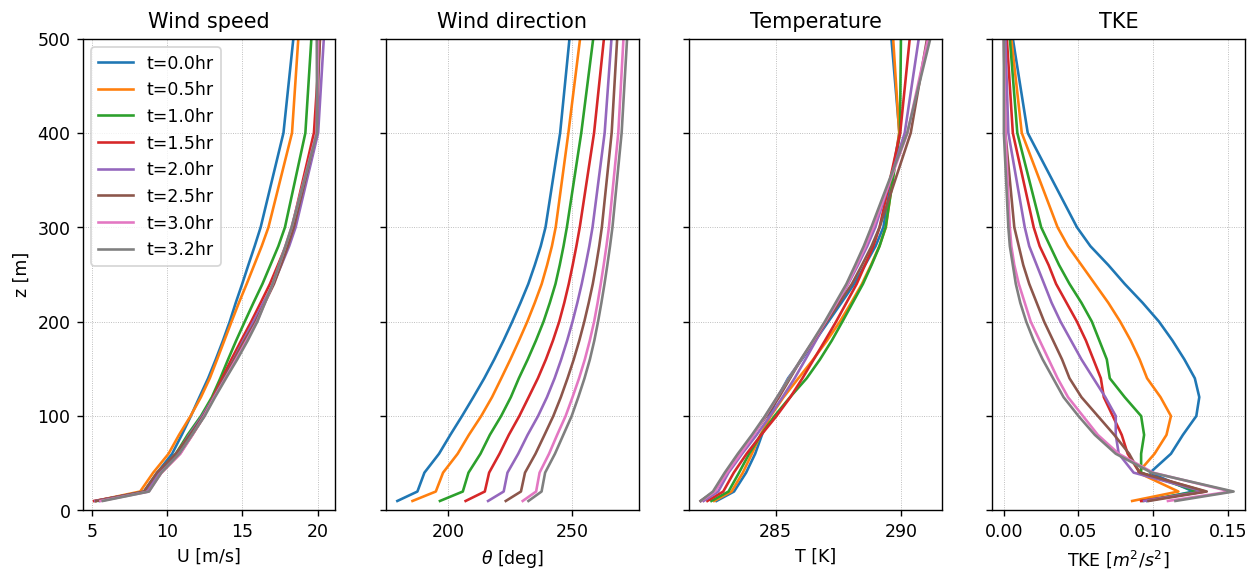

In [7]:
# Make some plots
fig, axs = plt.subplots(1,4, figsize=(12,5), sharey=True, dpi=125)
for t in [0, 1800, 3600, 5400, 7200, 9000, 10800, 11700]:
    i, ttime = find_nearest(np.array(alltimessec), t)
    axs[0].plot(allprofiles['wind_speed'][i,:],    allprofiles['height'][i,:], label='t=%0.1fhr'%(ttime/3600.0))
    axs[1].plot(allprofiles['wind_direction'][i,:], allprofiles['height'][i,:], label='t=%0.1fhr'%(ttime/3600.0))
    axs[2].plot(allprofiles['temperature'][i,:], allprofiles['height'][i,:], label='t=%0.1fhr'%(ttime/3600.0))
    axs[3].plot(allprofiles['tke'][i,:], allprofiles['height'][i,:], label='t=%0.1fhr'%(ttime/3600.0))

axs[0].legend()
axs[0].set_ylabel('z [m]')
axs[0].set_title('Wind speed')
axs[1].set_title('Wind direction')
axs[2].set_title('Temperature')
axs[3].set_title('TKE')

axs[0].set_xlabel('U [m/s]')
axs[1].set_xlabel('$\\theta$ [deg]')
axs[2].set_xlabel('T [K]')
axs[3].set_xlabel('TKE [$m^2/s^2$]')

for ax in axs:
    ax.set_ylim([0, 500])
    ax.grid(ls=':', lw=0.5)

In [8]:
# Write data to files
writedir = './MMC_profile_dat'
prefix   = 'MMC_profiles'
writefiles = False

savevars = ['wind_speed', 'wind_direction', 'temperature', 'tke', 'sst', 'surface_heat_flux', 'invMOL', 'ustar',]

if not os.path.exists(writedir):
    os.makedirs(writedir, exist_ok=True)

if writefiles:
    np.savetxt(writedir+'/'+prefix+'_times.dat', alltimessec)
    np.savetxt(writedir+'/'+prefix+'_heights.dat', allprofiles['height'][0,:])
    for v in savevars:
        np.savetxt(writedir+'/'+prefix+'_'+v+'.dat', allprofiles[v])

In [9]:
# Get hub-height relevant properties
zHH = 150.0
Uhh = []
WDhh = []
for ti,t in enumerate(alltimessec):
    Uhh.append(np.interp(zHH, allprofiles['height'][ti,:], allprofiles['wind_speed'][ti,:]))
    WDhh.append(np.interp(zHH, allprofiles['height'][ti,:], allprofiles['wind_direction'][ti,:]))
    
Uhh = np.array(Uhh)
WDhh = np.array(WDhh)

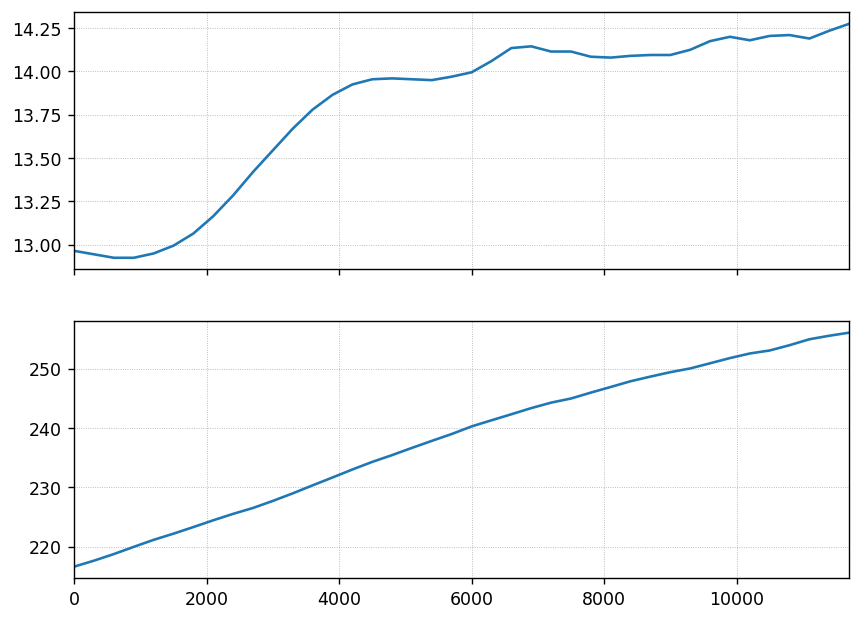

In [10]:
fig, axs=plt.subplots(2, 1, figsize=(8,6), sharex=True, dpi=125)
axs[0].plot(alltimessec, Uhh)
axs[1].plot(alltimessec, WDhh)

axs[0].set_xlim([0, 11700])
for ax in axs:
    ax.grid(ls=':', lw=0.5)

In [11]:
t1  = 8000.0
t2  = t1+900

tfilter=(t1<=np.array(alltimessec))&(np.array(alltimessec)<=t2)

In [12]:
print('Mean WS   = '+repr(np.mean(Uhh[tfilter])))
print('Mean WDir = '+repr(np.mean(WDhh[tfilter])))

print('STD WS    = '+repr(np.std(Uhh[tfilter])))
print('STD WDir  = '+repr(np.std(WDhh[tfilter])))

Mean WS   = 14.088333333333333
Mean WDir = 247.88333333333333
STD WS    = 0.006236095644622786
STD WDir  = 0.7178014271989868
